In [1]:
import timm

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 1
NAME = 'EXP_120'
SUFFIX =f'EFFNET_224_{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 224
BS = 512
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_224'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name


df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  del sys.path[0]


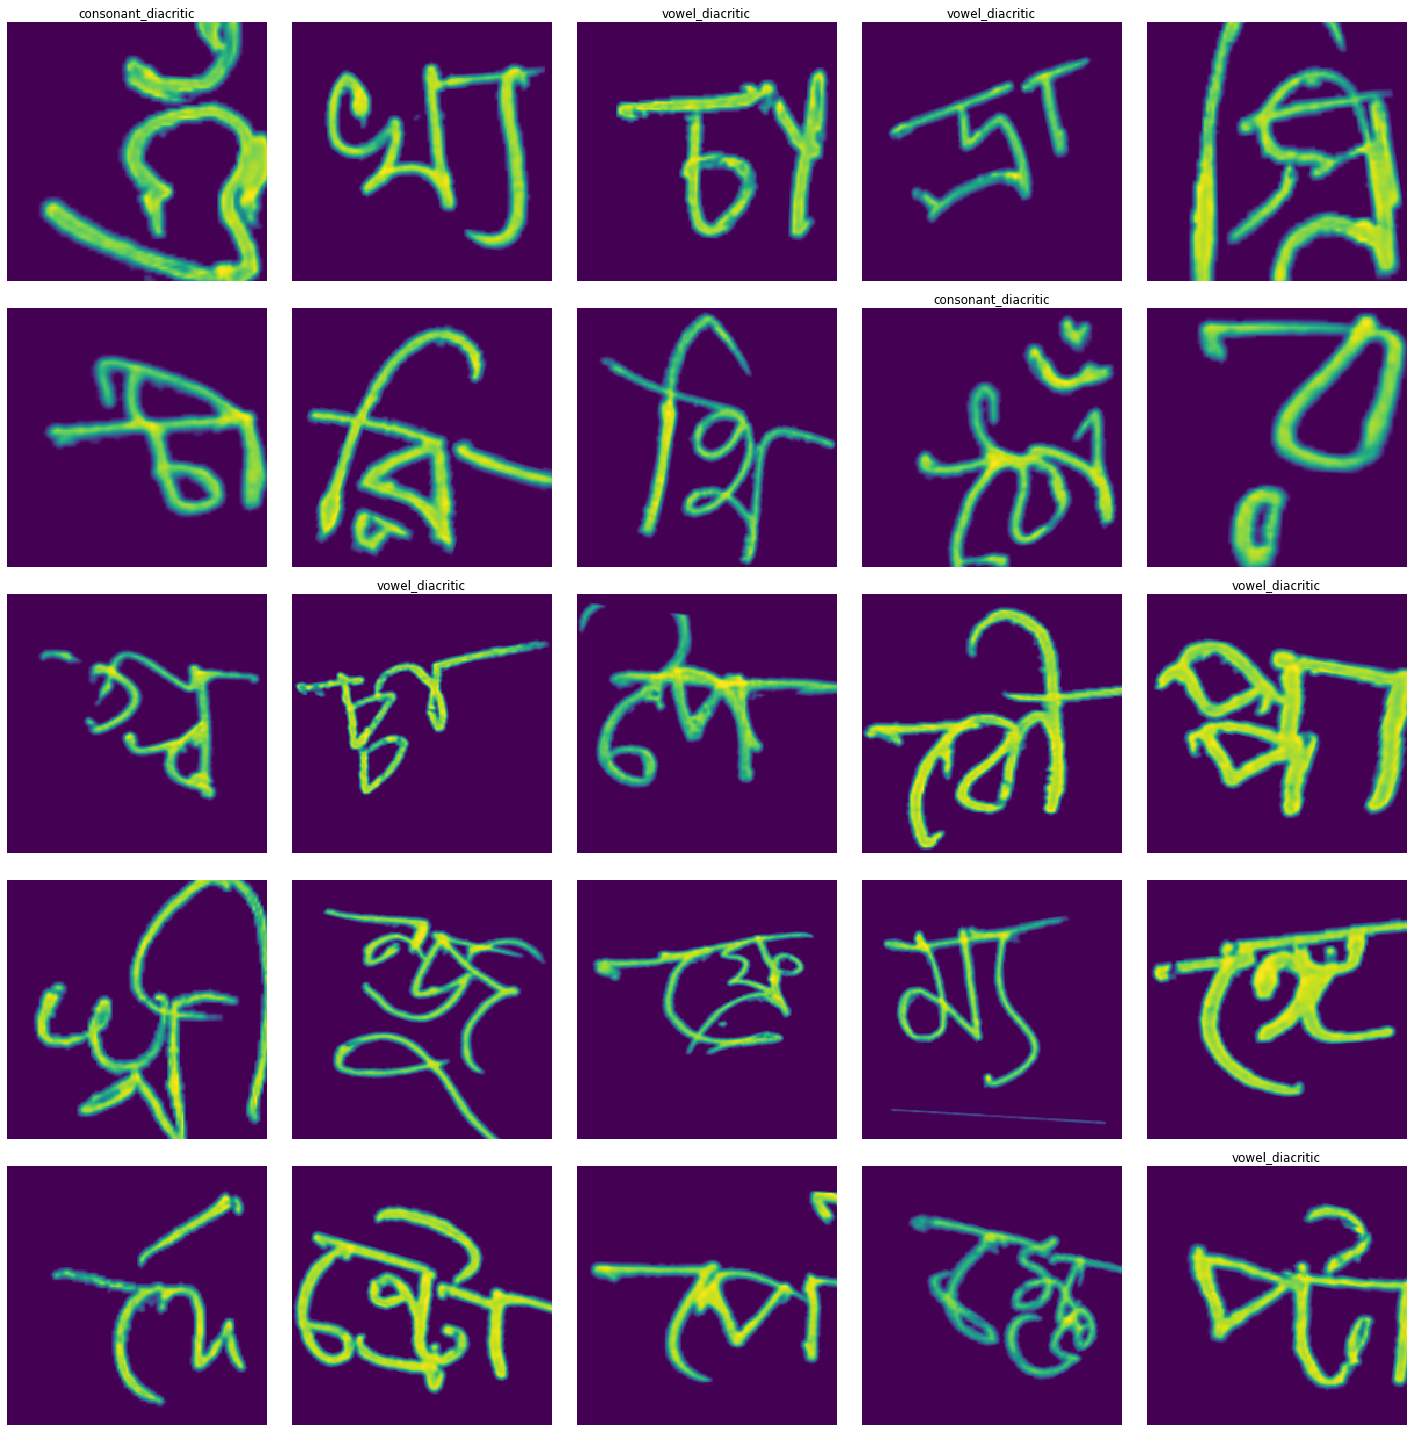

In [5]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder=TRAIN_IMG, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.2, max_zoom=1.15, max_rotate=20), size=SZ, padding_mode='zeros')
        .databunch(bs=BS)).normalize(([0.0786], [0.2130]))

data.show_batch()

In [6]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.2):
        super().__init__()
        layers =[] + bn_drop_lin(nc, n, bn=False)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)
    
    
    
class CustomHead(nn.Module):
    def __init__(self, arch, cut, nc, n=nunique, pre=False, ps=0.5, activ_mish=True):
        super().__init__()
        self.body=nn.Sequential(*list(arch.children())[:cut])
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        if activ_mish: 
            to_Mish(self.head1), to_Mish(self.head2), to_Mish(self.head3)
        
    def forward(self, x):
        x = self.body(x)
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        return x1, x2, x3
        return #torch.cat((F.softmax(x1, ), F.softmax(x2), F.softmax(x3)), 1)


In [9]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): 
        return 0.5 *(self.mp(x) + self.ap(x))

In [10]:
arch = timm.create_model('efficientnet_b0',pretrained=True)
arch = list(arch.children())[:-2]
w = arch[0].weight
arch[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
arch[0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
arch.append(AdaptiveConcatPool2d())
arch.append(Flatten())
arch = nn.Sequential(*arch)
model = CustomHead(arch=arch, cut=None, nc=1280)

In [11]:
model

CustomHead(
  (body): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), 

In [12]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return F.cross_entropy(x1,y[:,0],reduction=reduction) + F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          F.cross_entropy(x3,y[:,2],reduction=reduction)
    
    
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())
    

In [13]:
learn = Learner(data, model, loss_func=Loss_combine(), 
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()])
learn.model = nn.DataParallel(learn.model)
learn.unfreeze()
#learn.lr_find(wd=1e-2)

In [ ]:
learn.recorder.plot()
lr = 1e-3
plt.axvline(lr)

In [14]:
lr = 1e-3
learn.unfreeze()
learn.fit_one_cycle(20,lr , wd=1e-2,
                    callbacks = [SaveModelCallback(learn, every='improvement', monitor='metric_tot', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,3.692827,2.490772,0.368358,0.782377,0.652776,0.542967,03:59
1,0.971350,0.691468,0.853449,0.945274,0.933609,0.896445,03:52
2,0.623955,0.505470,0.887741,0.962534,0.953704,0.922930,03:53
3,0.513719,0.465997,0.901832,0.959527,0.958648,0.930460,03:51
4,0.455713,0.425783,0.906523,0.963481,0.944777,0.930326,03:52
5,0.398760,0.397829,0.913627,0.973065,0.960721,0.940260,03:52
6,0.334624,0.387722,0.918320,0.973869,0.964610,0.943780,03:52
7,0.291321,0.344126,0.922177,0.976155,0.971705,0.948054,03:51
8,0.256245,0.334054,0.933396,0.979479,0.966124,0.953099,03:52
9,0.219669,0.331283,0.928912,0.977918,0.970447,0.951547,03:51


Better model found at epoch 0 with metric_tot value: 0.5429671406745911.
Better model found at epoch 1 with metric_tot value: 0.8964449763298035.
Better model found at epoch 2 with metric_tot value: 0.9229302406311035.
Better model found at epoch 3 with metric_tot value: 0.9304596781730652.
Better model found at epoch 5 with metric_tot value: 0.9402601718902588.
Better model found at epoch 6 with metric_tot value: 0.9437796473503113.
Better model found at epoch 7 with metric_tot value: 0.9480535984039307.
Better model found at epoch 8 with metric_tot value: 0.9530987739562988.
Better model found at epoch 10 with metric_tot value: 0.9573958516120911.
Better model found at epoch 11 with metric_tot value: 0.9587192535400391.
Better model found at epoch 12 with metric_tot value: 0.9611907005310059.
Better model found at epoch 13 with metric_tot value: 0.9619224071502686.
Better model found at epoch 14 with metric_tot value: 0.9641076326370239.
Better model found at epoch 15 with metric_tot

In [15]:
!sudo shutdown

Shutdown scheduled for Tue 2020-01-14 17:09:10 UTC, use 'shutdown -c' to cancel.
